In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

import numpy as np
from stingray.pulse.search import epoch_folding_search, z_n_search
import matplotlib.pyplot as plt
import seaborn as sb
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10, 6)

# Simulate a dataset

Let us simulate a pulsar: we create a sinusoidal light curve and use Stingray's event simulator (in `Eventlist.simulate_times`) to simulate an event list with that light curve.

In [2]:
def sinusoid(times, frequency, baseline, amplitude, phase):
    return baseline + amplitude * np.sin(2 * np.pi * (frequency * times + phase))

In [3]:
from stingray import Lightcurve

period = 1.203501
mean_countrate = 50
pulsed_fraction = 0.2
bin_time = 0.01
obs_length = 3000

t = np.arange(0, obs_length, bin_time)

# The continuous light curve
counts = sinusoid(t, 1 / period, mean_countrate, 
                  0.5 * mean_countrate * pulsed_fraction, 0) * bin_time
lc = Lightcurve(t, counts, gti=[[-bin_time / 2, obs_length + bin_time / 2]],
                dt=bin_time)

In [4]:
from stingray.events import EventList

# use the light curve above to simulate an event list for this pulsar.
events = EventList()
events.simulate_times(lc)

# Pulsation search with epoch folding.

Let us assume we have already an estimate of the pulse period, for example because we found a candidate in the power density spectrum with a period of ~1.2.
We search around that period with the epoch folding.

Epoch folding consists of cutting the light curve at every pulse period and summing up all the intervals obtained in this way. We get an average pulse profile. In this example,

<IPython.core.display.Javascript object>


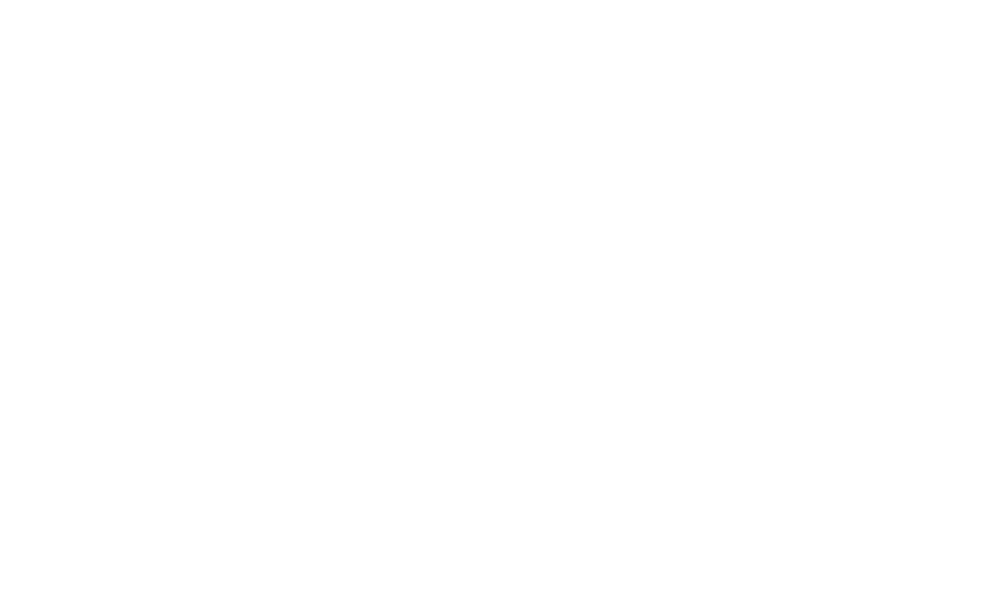

<IPython.core.display.Javascript object>


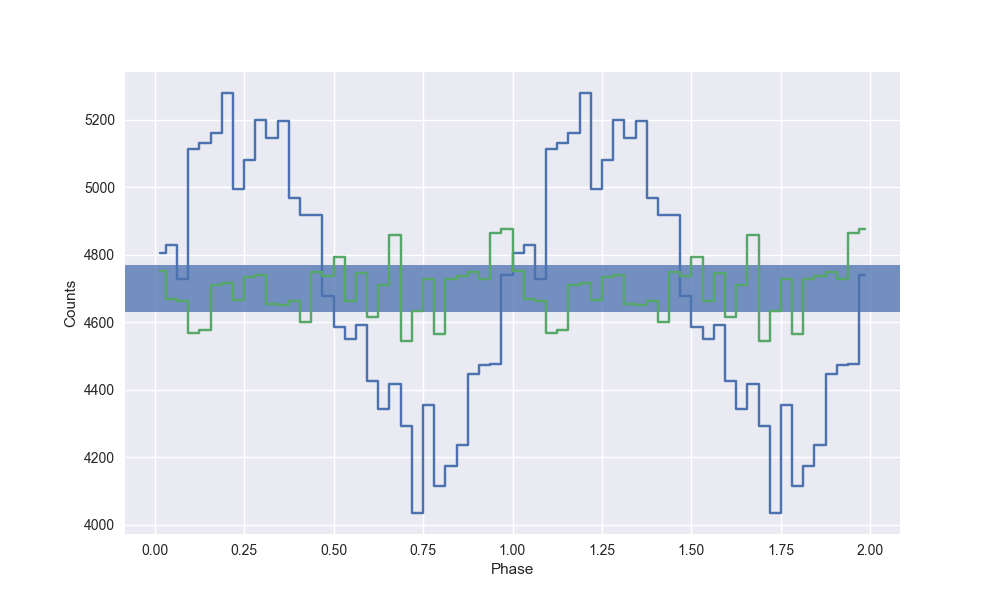

In [5]:
from stingray.pulse.pulsar import fold_events
from stingray.pulse.search import plot_profile
nbin = 32

plt.figure()
ph, profile, profile_err = fold_events(events.time, 1/period, nbin=nbin)

_ = plot_profile(ph, profile)

where the pulse was plotted twice for visual clarity. If the candidate pulse frequency was even slightly incorrect, we would have obtained a much shallower pulse profile, or no pulse profile at all. E.g.

In [6]:
ph, profile, profile_err = fold_events(events.time, 1/1.1, nbin=nbin)

_ = plot_profile(ph, profile)

Therefore, typically we try a number of frequencies around the candidate we found with the power spectrum or other means, and search for the frequency that gives the "best" pulsed profile. 
How do we evaluate this best frequency?
We use the chi squared statistics. 

We use a flat pulsed profile (no pulsation) as model, and we calculate the chi square of the actual pulsed profile with respect to this flat model:

$$
S = \sum_i\frac{(P_i - \overline{P})^2}{\sigma^2}
$$
If there is no pulsation, the chi squared will assume a random value distributed around the number of degrees of freedom $n - 1$ (where $n$ is the number of bins in the profile) with a well defined statistical distribution ($\chi^2_{n - 1}$). If there is pulsation, the value will be much larger.
Stingray has a function that does this: `stingray.pulse.search.epoch_folding_search`.

For the frequency resolution of the periodogram, one usually chooses _at least_ the same frequency resolution of the FFT, i. e., $df_{\rm min}=1/(t_1 - t_0)$. In most cases, a certain degree of oversampling is used.

<IPython.core.display.Javascript object>


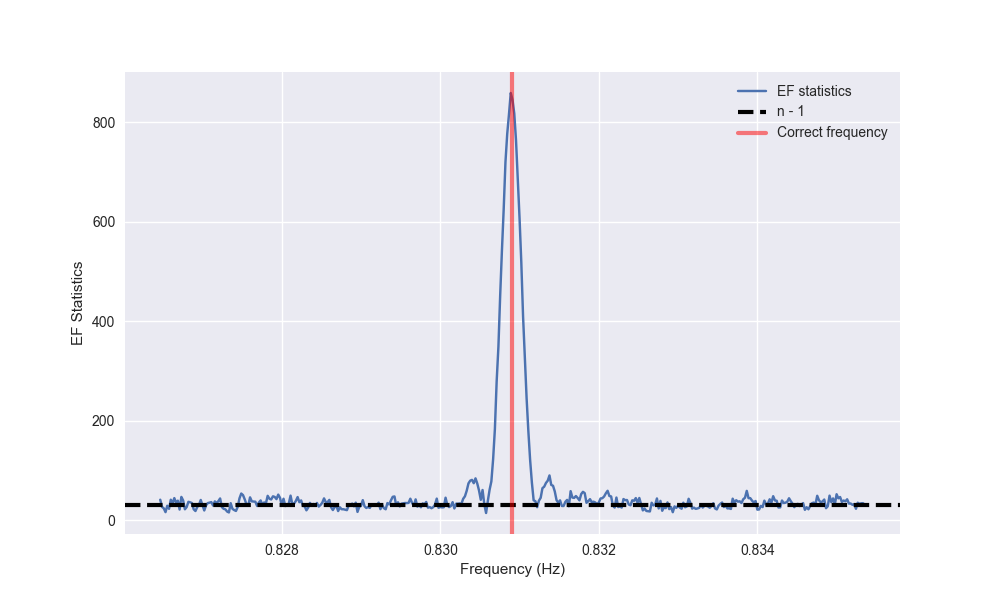

In [7]:
# We will search for pulsations over a range of frequencies around the known pulsation period.
df_min = 1/obs_length
oversampling=15
df = df_min / oversampling
frequencies = np.arange(1/period - 200 * df, 1/period + 200 * df, df)

freq, efstat = epoch_folding_search(events.time, frequencies, nbin=nbin)

# ---- PLOTTING --------
plt.figure()
plt.plot(freq, efstat, label='EF statistics')
plt.axhline(nbin - 1, ls='--', lw=3, color='k', label='n - 1')
plt.axvline(1/period, lw=3, alpha=0.5, color='r', label='Correct frequency')
plt.xlabel('Frequency (Hz)')
plt.ylabel('EF Statistics')
_ = plt.legend()

A peak is definitely there. 
Far from the peak, the periodogram follows approximately a **$\chi^2$ distribution with $n - 1$ degrees of freedom**, where $n$ is the number of bins in the pulse profile used to calculate the statistics. In fact, its mean is $n-1$ as shown in the figure. 

But close to the correct frequency, as described in Leahy et al. 1983, 1987 the peak in the epoch folding periodogram has the shape of a **sinc squared function** (whose secondary lobes are in this case barely visible above noise).

# Z-squared search
The epoch folding statistics has no information on the actual shape of the profile. 

A better method is the **$Z^2$ statistics** (Buccheri et al. 1983), which is conceptually similar to the Epoch folding but has high values when the signal is well described by a small number of **sinusoidal harmonics**. 

$Z^2_n = \dfrac{2}{N} \sum_{k=1}^n \left[{\left(\sum_{j=1}^N \cos k \phi_j\right)}^2 + {\left(\sum_{j=1}^N \sin k \phi_j\right)}^2\right]$

Where $N$ is the number of photons, $n$ is the number of harmonics, $\phi_j$ are the phases corresponding to the event arrival times $t_j$ ($\phi_j = \nu t_j$, where $\nu$ is the pulse frequency).

The $Z_n^2$ statistics defined in this way, far from the pulsed profile, follows a $\chi^2_n$ distribution, where $n$ is the number of harmonics this time.

Stingray implements the $Z$ search in `stingray.pulse.search.z_n_search`.
The standard $Z^2$ search calculates the phase of each photon and calculates the sinusoidal functions above for each photon. This is very computationally expensive if the number of photons is high. Therefore, in Stingray, the search is performed by binning the pulse profile first and using the phases of the folded profile in the formula above, multiplying the squared sinusoids of the phases of the pulse profile by a weight corresponding to the number of photons at each phase.

$Z^2_n = \dfrac{2}{\sum_j{w_j}} \sum_{k=1}^n \left[{\left(\sum_{j=1}^m w_j \cos k \phi_j\right)}^2 + {\left(\sum_{j=1}^m w_j \sin k \phi_j\right)}^2\right]$

Since the sinusoids are only executed on a small number of bins, while the epoch folding procedure just consists of a very fast histogram-like operation, the speedup of this new formula is obvious. Care must be put into the choice of the number of bins, in order to maintain a good approximation even when the number of harmonics is high. As a rule of thumb, use _a number of bins at least 10 times larger than the number of harmonics_.

<IPython.core.display.Javascript object>


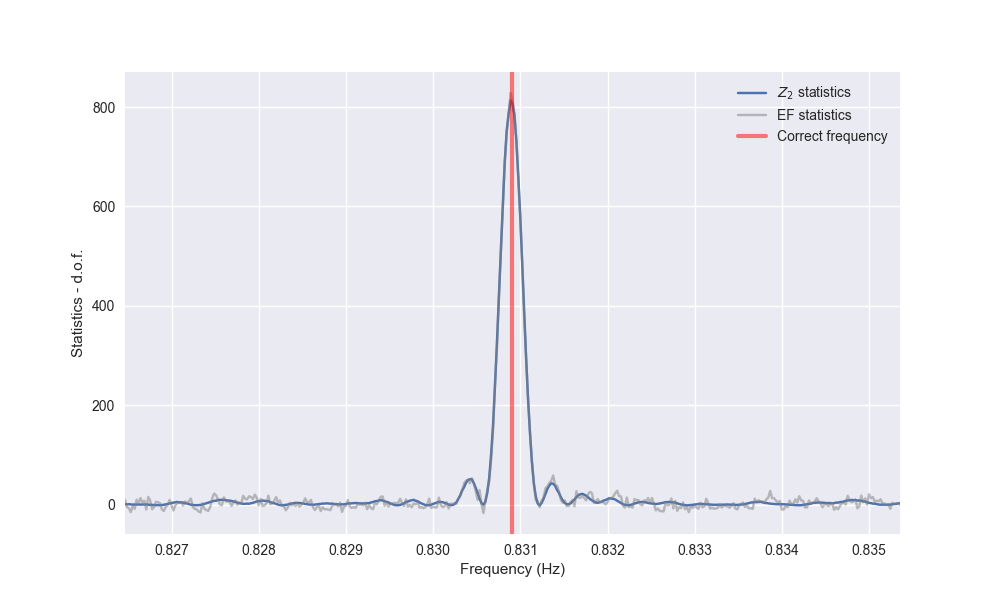

<IPython.core.display.Javascript object>


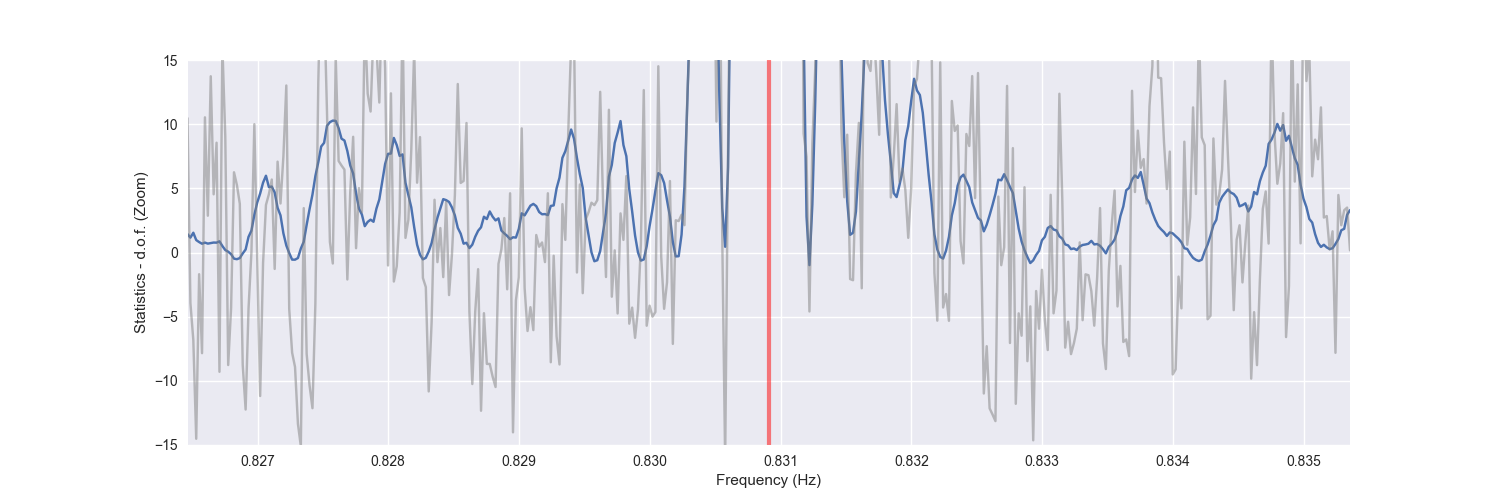

In [8]:
# We will search for pulsations over a range of frequencies around the known pulsation period.
nharm = 1
freq, zstat = z_n_search(events.time, frequencies, nbin=nbin, nharm=nharm)

# ---- PLOTTING --------
plt.figure()
plt.plot(freq, (zstat - nharm), label='$Z_2$ statistics')
plt.plot(freq, efstat - nbin + 1, color='gray', label='EF statistics', alpha=0.5)

plt.axvline(1/period, color='r', lw=3, alpha=0.5, label='Correct frequency')
plt.xlim([frequencies[0], frequencies[-1]])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Statistics - d.o.f.')
plt.legend()
plt.figure(figsize=(15, 5))
plt.plot(freq, (zstat - nharm), label='$Z_2$ statistics')
plt.plot(freq, efstat - nbin + 1, color='gray', label='EF statistics', alpha=0.5)

plt.axvline(1/period, color='r', lw=3, alpha=0.5, label='Correct frequency')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Statistics - d.o.f. (Zoom)')

plt.ylim([-15, 15])
_ = plt.xlim([frequencies[0], frequencies[-1]])


# Thresholding

When can a peak in the EF or $Z_n^2$ periodogram be considered a pulsation?

Since both the EF and $Z_n^2$ of noise follow precise statistical distributions ($\chi^2_{\rm nbin}$ in one case, $\chi^2_n$ in the other), we can use the inverse survival functions of these statistical distributions to find the peaks that are not expected by noise.

In Stingray, the thresholds are defined in `stingray.pulse.pulsar.fold_detection_level` and `stingray.pulse.pulsar.z2_n_detection_level` respectively.

The `ntrial` parameter should be set to an estimate of the statistically independent frequencies in the periodogram. A good estimate can be 

$$N_{\rm trial} \sim (f_{\rm max} - f_{\rm min}) / df_{\rm min} =(f_{\rm max} - f_{\rm min}) (t_1 - t_0)$$,
where $f_{\rm min}$ and $f_{\rm max}$ are the maximum and minimum frequencies of the periodogram, $df_{\rm min}$ was defined above and $t_0$ ans $t_1$ the start and end of the observation.

Moreover, the `stingray.pulse.search.search_best_peaks` helps finding the best value for nearby candidates.

<IPython.core.display.Javascript object>


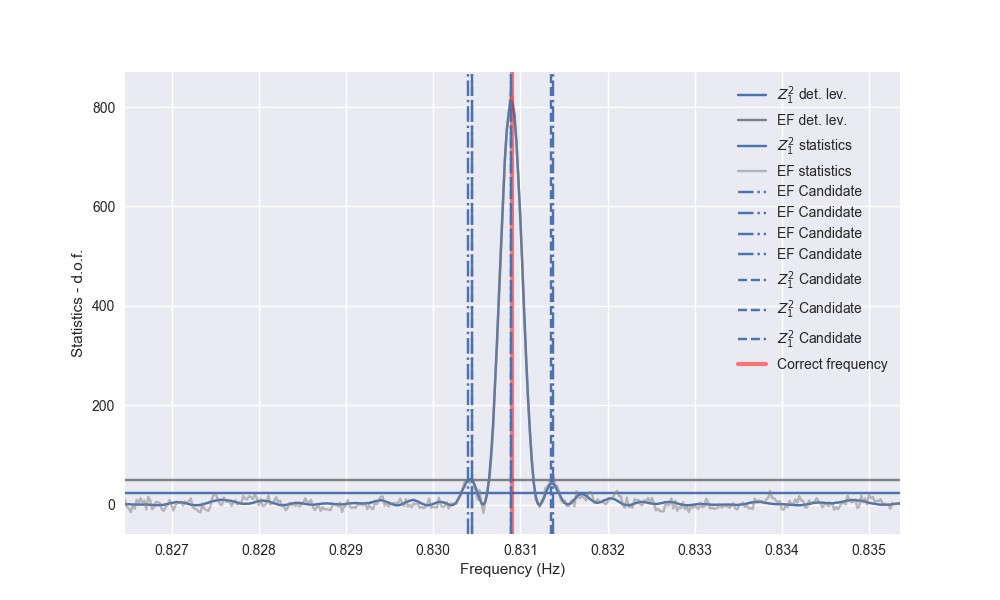

<IPython.core.display.Javascript object>


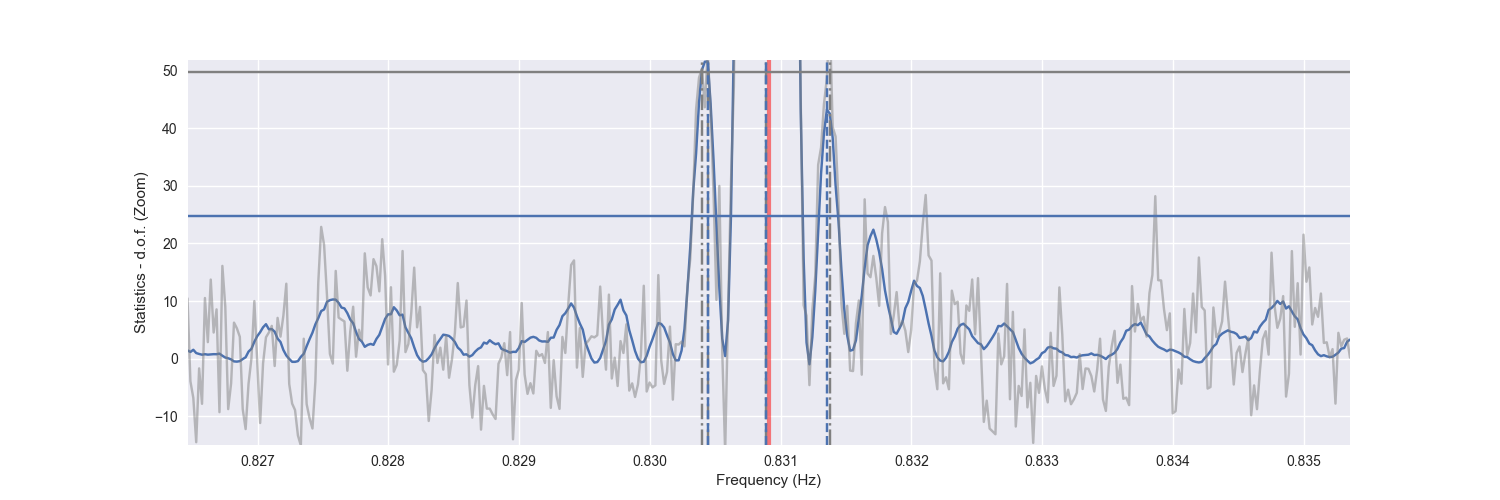

In [9]:
from stingray.pulse.search import search_best_peaks
from stingray.pulse.pulsar import fold_detection_level, z2_n_detection_level

ntrial = (frequencies[-1] - frequencies[0]) / df_min
z_detlev = z2_n_detection_level(n=1, epsilon=0.001, ntrial=len(freq))
ef_detlev = fold_detection_level(nbin, epsilon=0.001, ntrial=len(freq))

cand_freqs_ef, cand_stat_ef = search_best_peaks(freq, efstat, ef_detlev)
cand_freqs_z, cand_stat_z = search_best_peaks(freq, zstat, z_detlev)

# ---- PLOTTING --------
plt.figure()
plt.axhline(z_detlev - nharm, label='$Z^2_1$ det. lev.')
plt.axhline(ef_detlev - nbin + 1, label='EF det. lev.', color='gray')

plt.plot(freq, (zstat - nharm), label='$Z^2_1$ statistics')
plt.plot(freq, efstat - nbin + 1, color='gray', label='EF statistics', alpha=0.5)

for c in cand_freqs_ef:
    plt.axvline(c, ls='-.', label='EF Candidate', zorder=10)
for c in cand_freqs_z:
    plt.axvline(c, ls='--', label='$Z^2_1$ Candidate', zorder=10)
    
plt.axvline(1/period, color='r', lw=3, alpha=0.5, label='Correct frequency')
plt.xlim([frequencies[0], frequencies[-1]])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Statistics - d.o.f.')
plt.legend()

plt.figure(figsize=(15, 5))
plt.plot(freq, (zstat - nharm), label='$Z_2$ statistics')
plt.plot(freq, efstat - nbin + 1, color='gray', label='EF statistics', alpha=0.5)

plt.axvline(1/period, color='r', lw=3, alpha=0.5, label='Correct frequency')
plt.axhline(z_detlev - nharm, label='$Z^2_1$ det. lev.', zorder=10)
plt.axhline(ef_detlev - nbin + 1, label='EF det. lev.', color='gray', zorder=10)

for c in cand_freqs_ef:
    plt.axvline(c, ls='-.', label='EF Candidate', color='gray', zorder=10)
for c in cand_freqs_z:
    plt.axvline(c, ls='--', label='$Z^2_1$ Candidate', zorder=10)

plt.xlabel('Frequency (Hz)')
plt.ylabel('Statistics - d.o.f. (Zoom)')

plt.ylim([-15, ef_detlev - nbin + 3])
_ = plt.xlim([frequencies[0], frequencies[-1]])

Note that the side lobes of the sinc squared-like shape are producing spurious candidates here. For now, we do not have a method to eliminate these fairly obvious patterns, but it will be implemented in future releases

# Fit peak with Sinc-squared and Gaussian functions

As we saw earlier, if the pulse frequency is stable during the observation, the peak shape is a **Sinc squared function**. Therefore we fit it to the peak with the function `stingray.pulse.modeling.fit_sinc`.  
We have two possibilities:

+ if `obs_length` is the length of the observation. If it is defined, it fixes width to $1/(\pi*obs length)$, as expected from epoch folding periodograms. The other two free parameters are `amplitude` and `mean`.
+ if it is not defined, the `width` parameter can be used.

On the other hand, if the pulse frequency varies slightly, the peak oscillate and the integrated profile is a bell-shaped function. We can fit it with a **Gaussian function**  (`stingray.pulse.modeling.fit_gaussian`) with the standard parameters: `amplitude`, `mean`, `stddev`.

We also provide the user with the constrains `fixed`, `tied`, `bounds`, in order to fix, link and/or constrain parameters.




In [10]:
from stingray.pulse.modeling import fit_sinc

fs=fit_sinc(freq, efstat-(nbin-1),amp=max(efstat-(nbin-1)), mean=cand_freqs_ef[0], 
            obs_length=obs_length)

<IPython.core.display.Javascript object>


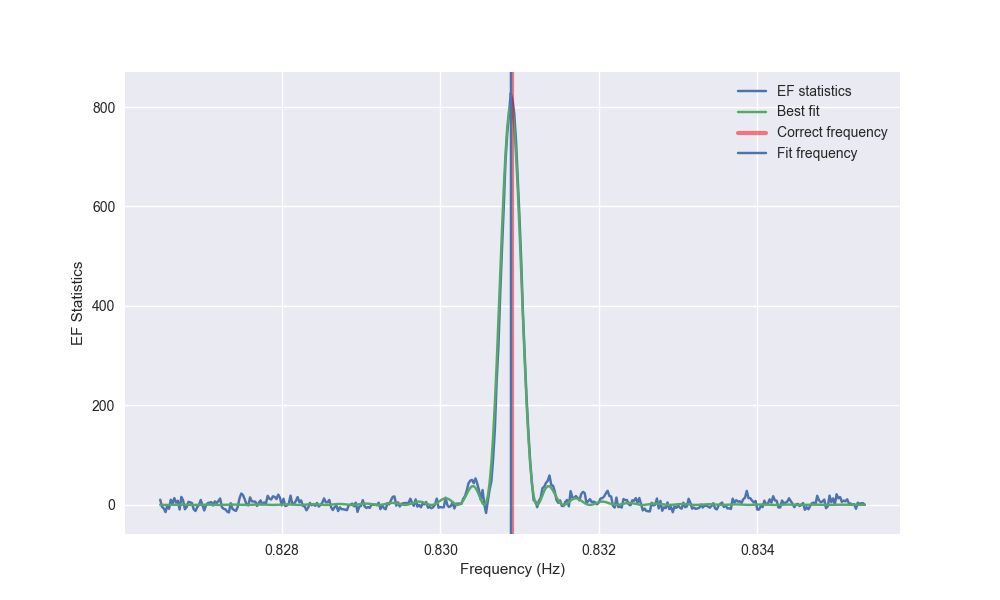

<IPython.core.display.Javascript object>


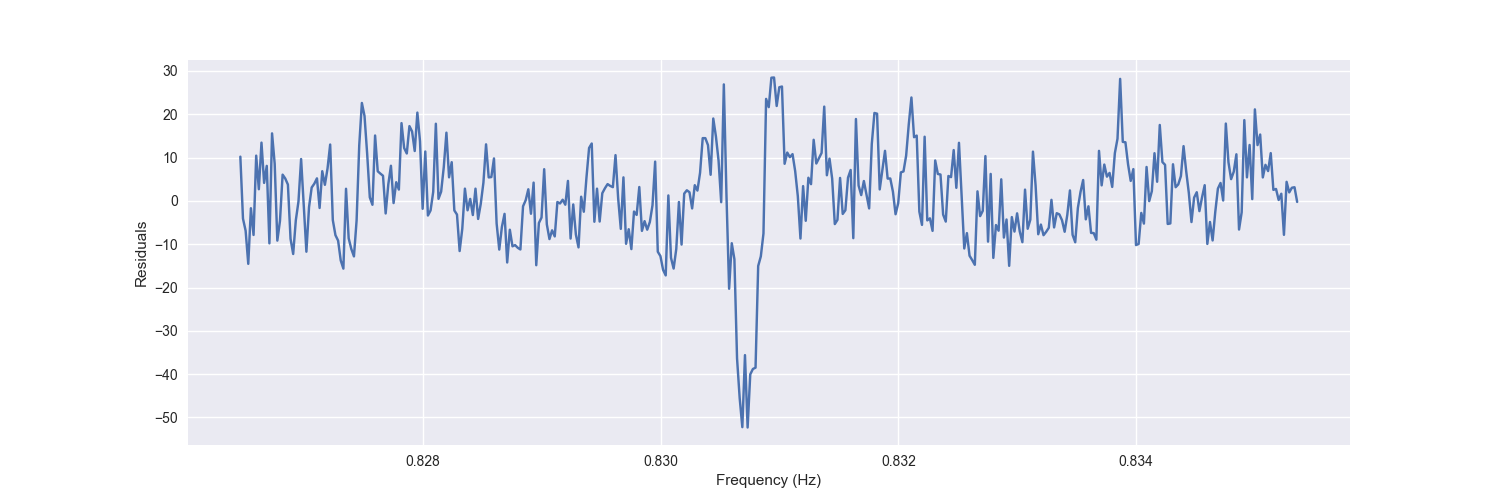

In [11]:
# ---- PLOTTING --------
plt.figure()
plt.plot(freq, efstat-(nbin-1), label='EF statistics')
plt.plot(freq, fs(freq), label='Best fit')
plt.axvline(1/period, lw=3, alpha=0.5, color='r', label='Correct frequency')
plt.axvline(fs.mean, label='Fit frequency')

plt.xlabel('Frequency (Hz)')
plt.ylabel('EF Statistics')
plt.legend()

plt.figure(figsize=(15, 5))
plt.plot(freq, efstat-(nbin-1)-fs(freq))
plt.xlabel('Frequency (Hz)')
_ = plt.ylabel('Residuals')

On the other hand, if we want to fit with a Gaussian:

In [12]:
from stingray.pulse.modeling import fit_gaussian

fg=fit_gaussian(freq, efstat-(nbin-1),amplitude=max(efstat-(nbin-1)), 
                mean=cand_freqs_ef[0], stddev=1/(np.pi*obs_length))

<IPython.core.display.Javascript object>


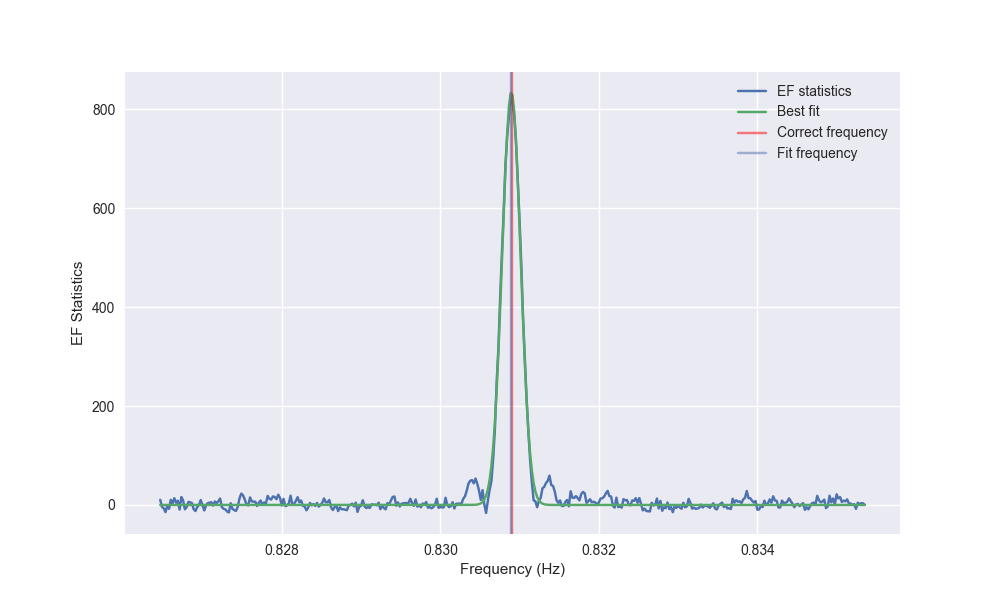

<IPython.core.display.Javascript object>


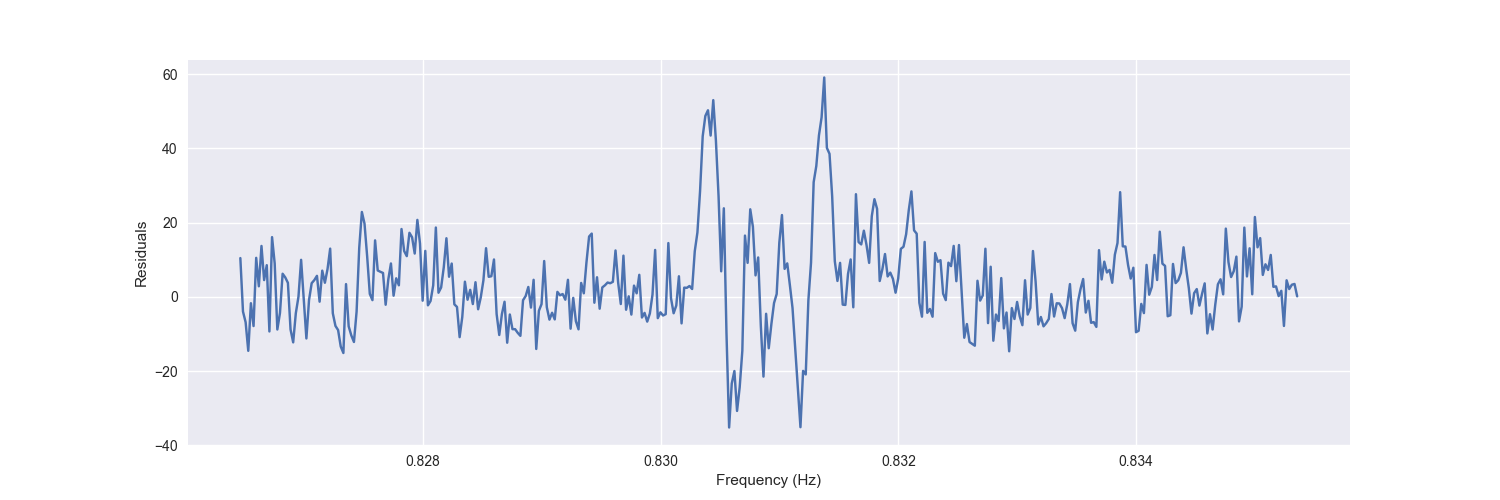

In [13]:
# ---- PLOTTING --------
plt.figure()
plt.plot(freq, efstat-(nbin-1), label='EF statistics')
plt.plot(freq, fg(freq), label='Best fit')
plt.axvline(1/period, alpha=0.5, color='r', label='Correct frequency')
plt.axvline(fg.mean, alpha=0.5, label='Fit frequency')

plt.xlabel('Frequency (Hz)')
plt.ylabel('EF Statistics')
plt.legend()

plt.figure(figsize=(15, 5))
plt.plot(freq, efstat-(nbin-1)-fg(freq))
plt.xlabel('Frequency (Hz)')
_ = plt.ylabel('Residuals')

# Phaseogram

Let us now calculate the phaseogram and plot it with the pulse profile. 
We do that with the functions `phaseogram`, `plot_profile` and `plot_phaseogram` from `stingray.pulse.search`

<IPython.core.display.Javascript object>


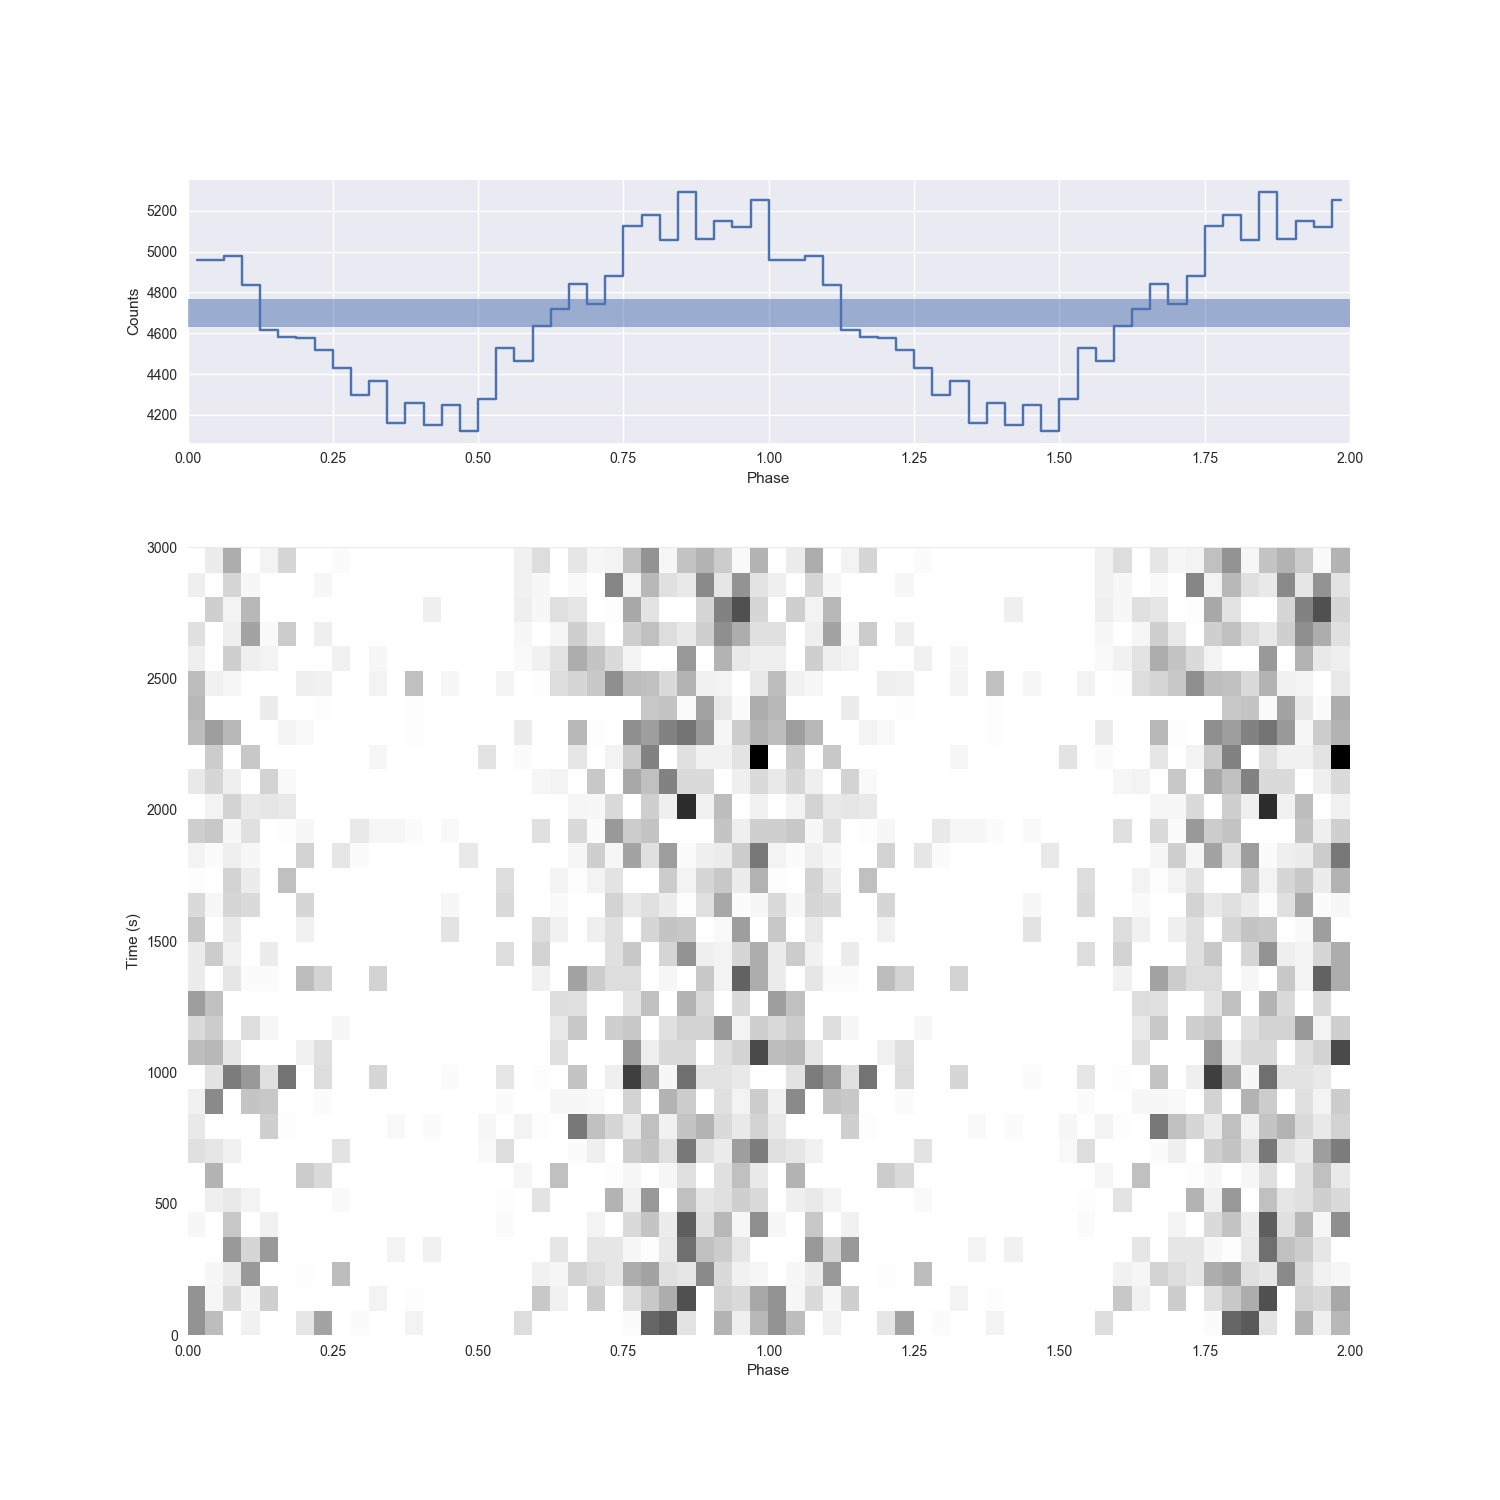

In [14]:
from stingray.pulse.search import phaseogram, plot_phaseogram, plot_profile
from matplotlib.gridspec import GridSpec

# Calculate the phaseogram
phaseogr, phases, times, additional_info = \
            phaseogram(events.time, cand_freqs_ef[0], return_plot=True, nph=nbin, nt=32)
    
# ---- PLOTTING --------

# Plot on a grid
plt.figure(figsize=(15, 15))
gs = GridSpec(2, 1, height_ratios=(1, 3))
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1], sharex=ax0)

mean_phases = (phases[:-1] + phases[1:]) / 2
plot_profile(mean_phases, np.sum(phaseogr, axis=1), ax=ax0)
# Note that we can pass arguments to plt.pcolormesh, in this case vmin
_ = plot_phaseogram(phaseogr, phases, times, ax=ax1, vmin=np.median(phaseogr))

In [15]:
def shift_phaseogram(phaseogr, tseg, delay_fun):
    """Shift the phaseogram rows according to an input delay function.

    Parameters
    ----------
    phaseogr : 2-d array
        The phaseogram, as returned by ``phaseogram``
    freq : float
        The pulse frequency
    tseg : float
        The integration time for each row of the phaseogram
    delay_fun : function
        Function that gives the delay (in seconds) for each row of the
        phaseogram

    Returns
    -------
    phaseogram_new : 2-d array
        The shifted phaseogram

    """
    # Assume that the phaseogram is repeated twice in phase
    nbin = phaseogr.shape[0] / 2
    ntimes = phaseogr.shape[1]

    times = np.arange(0, tseg * ntimes, tseg)
    phase_delays = delay_fun(times)  # This gives the delay in units of time!

    delayed_bins = np.array(np.rint(phase_delays * nbin), dtype=int)
    phaseogram_new = np.copy(phaseogr)
    for i in range(ntimes):
        phaseogram_new[:, i] = np.roll(phaseogram_new[:, i], 
                                       delayed_bins[i])

    return phaseogram_new


def interactive_phaseogram(phas, binx, biny, df=0, dfdot=0):
    import matplotlib.pyplot as plt
    from matplotlib.widgets import Slider, Button, RadioButtons

    fig, ax = plt.subplots()
    plt.subplots_adjust(left=0.25, bottom=0.30)
    tseg = np.median(np.diff(biny))
    tobs = tseg * phas.shape[0]
    delta_df_start = 2 / tobs
    df_order_of_mag = np.int(np.log10(delta_df_start))
    delta_df = delta_df_start / 10 ** df_order_of_mag

    delta_dfdot_start = 8 / tobs ** 2
    dfdot_order_of_mag = np.int(np.log10(delta_dfdot_start))
    delta_dfdot = delta_dfdot_start / 10 ** dfdot_order_of_mag

    pcolor = plt.pcolormesh(binx, biny, phas.T, cmap='magma')
    l,  = plt.plot(np.ones_like(biny), biny, zorder=10, lw=2, color='w')
    plt.xlabel('Time')
    plt.ylabel('Phase')
    plt.colorbar()

    axcolor = 'lightgoldenrodyellow'
    axfreq = plt.axes([0.25, 0.1, 0.5, 0.03], facecolor=axcolor)
    axfdot = plt.axes([0.25, 0.15, 0.5, 0.03], facecolor=axcolor)
    axpepoch = plt.axes([0.25, 0.2, 0.5, 0.03], facecolor=axcolor)


    sfreq = Slider(axfreq, 'Delta freq x$10^{}$'.format(df_order_of_mag), 
                   -delta_df, delta_df, valinit=df)
    sfdot = Slider(axfdot, 'Delta fdot x$10^{}$'.format(dfdot_order_of_mag), 
                   -delta_dfdot, delta_dfdot, valinit=dfdot)
    spepoch = Slider(axpepoch, 'Delta pepoch', 
                     0, biny[-1] - biny[0], valinit=0)

    def update(val):
        fdot = sfdot.val * 10 ** dfdot_order_of_mag
        freq = sfreq.val * 10 ** df_order_of_mag
        pepoch = spepoch.val
        delay_fun = lambda times: (times - pepoch) * freq + \
                                   0.5 * (times - pepoch) ** 2 * fdot
        new_phaseogram = shift_phaseogram(phas, tseg, delay_fun)
        pcolor.set_array(new_phaseogram.T.ravel())
        l.set_xdata(1 + delay_fun(biny - biny[0]))
        fig.canvas.draw_idle()

    sfreq.on_changed(update)
    sfdot.on_changed(update)
    spepoch.on_changed(update)

    resetax = plt.axes([0.8, 0.020, 0.1, 0.04])
    button = Button(resetax, 'Reset', color=axcolor, hovercolor='0.975')

    def reset(event):
        sfreq.reset()
        sfdot.reset()

    button.on_clicked(reset)

    plt.show()

<IPython.core.display.Javascript object>


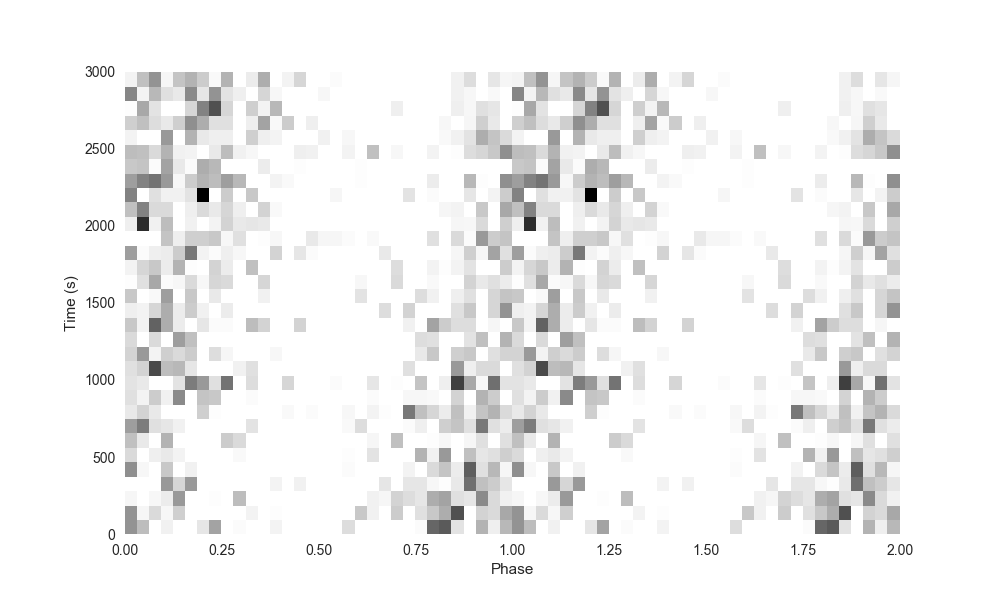

In [16]:
f0 = 0.0001
fdot = 0
delay_fun = lambda times: times * f0 + 0.5 * times ** 2 * fdot

new_phaseogr = shift_phaseogram(phaseogr, times[1] - times[0], delay_fun)
_ = plot_phaseogram(new_phaseogr, phases, times, vmin=np.median(phaseogr))

<IPython.core.display.Javascript object>


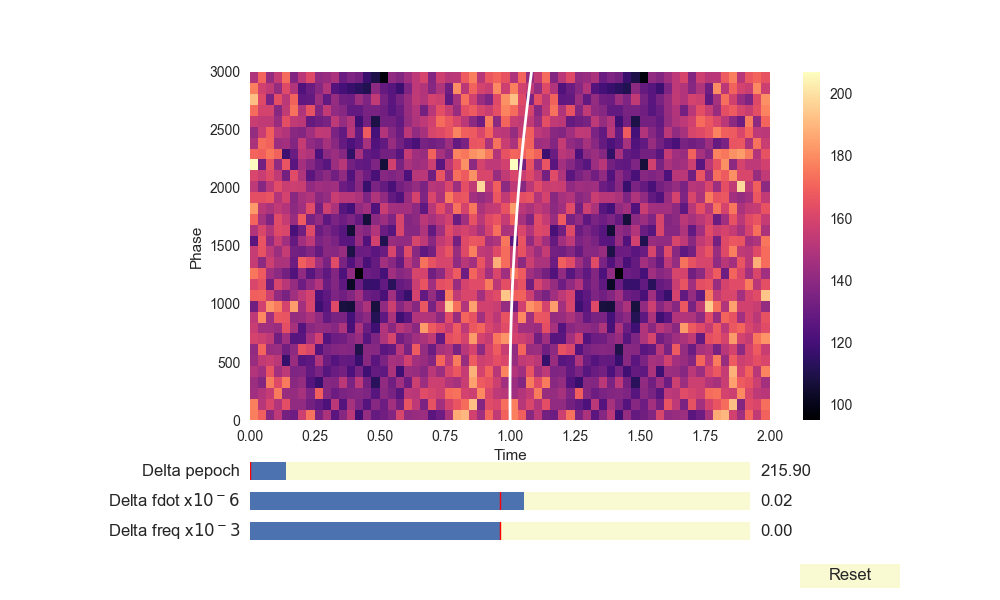

In [17]:
interactive_phaseogram(phaseogr, phases, times, df=0, dfdot=0)